In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)

columns_measurement = inspector.get_columns('measurement')

for column in columns_measurement:
    print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Climate Analysis

In [11]:
# Calculate the date 1 year ago from the last data point in the database
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest_date

twelve_months_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
twelve_months_ago

datetime.date(2016, 8, 23)

In [12]:
# Perform a query to retrieve the data and precipitation scores

prcp = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= twelve_months_ago).all()



In [13]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date

prcp_df = pd.DataFrame(prcp, columns=['Date','Precipitation'])
prcp_df.set_index('Date', inplace=True)
prcp_df = prcp_df.sort_values(by='Date', ascending=True)


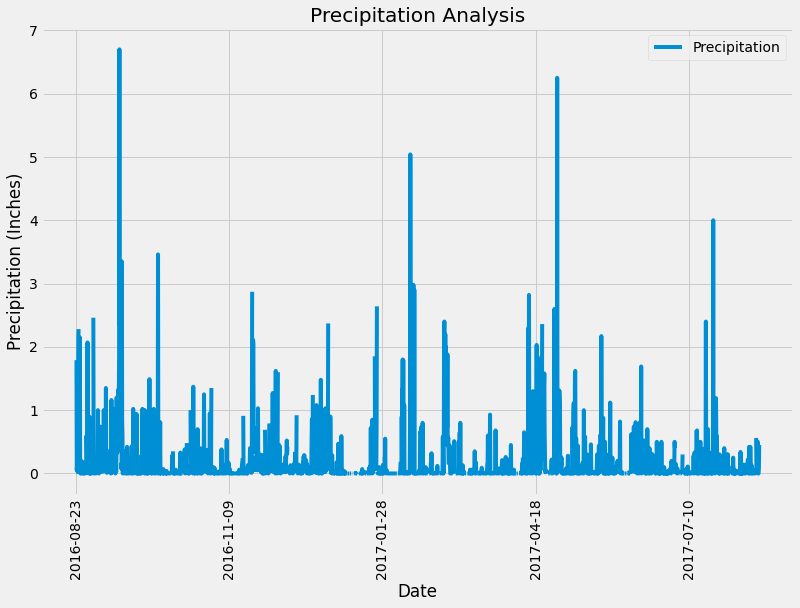

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data

prcp_df.plot(rot=90, figsize=(12,8))

plt.ylabel('Precipitation (Inches)')
plt.title("Precipitation Analysis")
plt.show()

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data

prcp_df[["Precipitation"]].describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Inspecting station class

columns_station = inspector.get_columns('station')

for column in columns_station:
    print(column['name'])

id
station
name
latitude
longitude
elevation


In [17]:
# Design a query to show how many stations are available in this dataset?

for row in session.query(Station):
    print(row.station)

station_count = session.query(Station.station).group_by(Station.station).count()
station_count


USC00519397
USC00513117
USC00514830
USC00517948
USC00518838
USC00519523
USC00519281
USC00511918
USC00516128


9

In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

combined_data = session.query(Station.station, Station.name, func.count(Measurement.tobs)).\
filter(Measurement.station == Station.station).\
group_by(Station.station).\
order_by(func.count(Measurement.tobs).desc()).all()

combined_data

# Station -'USC00519281', 'WAIHEE 837.5, HI US'- has the higher number of observations with 2772.



[('USC00519281', 'WAIHEE 837.5, HI US', 2772),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 2724),
 ('USC00513117', 'KANEOHE 838.1, HI US', 2709),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979),
 ('USC00517948', 'PEARL CITY, HI US', 1372),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)]

In [19]:
# Design a query to retrieve the last 12 months of temperature observation data (TOBS).
# Filter by the station with the highest number of observations.

tobs = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.date >= '2016-08-23').\
    filter(Measurement.station == 'USC00519281').all()



In [20]:
# Conver the results into pandas for plotting.

tobs_df = pd.DataFrame(tobs, columns=['Station','Date','Tobs'])

tobs_df = tobs_df.sort_values(by='Date', ascending=True)

tobs_df

,Station,Date,Tobs
0,USC00519281,2016-08-23,77.0
1,USC00519281,2016-08-24,77.0
2,USC00519281,2016-08-25,80.0
3,USC00519281,2016-08-26,80.0
4,USC00519281,2016-08-27,75.0
...,...,...,...
347,USC00519281,2017-08-14,77.0
348,USC00519281,2017-08-15,77.0
349,USC00519281,2017-08-16,76.0
350,USC00519281,2017-08-17,76.0


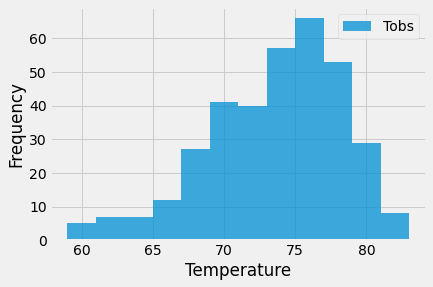

In [21]:
# Plot the results as a histogram with bins=12.

plt.hist(tobs_df['Tobs'], bins=12, alpha=0.75, label = "Tobs")
plt.legend(loc=1)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()


## Temperature Analysis I

In [22]:
from scipy import stats
from numpy import mean

# Querying the temperature results from June and December 

month1 = '06'
month2 = '12'

temp_jun = session.query(Measurement.tobs).\
    filter(func.strftime("%m", Measurement.date) == month1)

temp_dec = session.query(Measurement).\
    filter(func.strftime("%m", Measurement.date) == month2)

# Generating a list for June temperatures to calculate mean

temp_jun_list = []

for temp in temp_jun:
    if type(temp.tobs) == float:
        temp_jun_list.append(temp.tobs)
    
len(temp_jun_list)

# Generating a list for December temperatures to calculate mean

temp_dec_list = []

for temp in temp_dec:
    if type(temp.tobs) == float:
        temp_dec_list.append(temp.tobs)
    
len(temp_dec_list)

# Calculating Mean

mean(temp_jun_list)
mean(temp_dec_list)



71.04152933421226

In [23]:
# Unpaired T-test for June and December temperatures

stats.ttest_ind(temp_dec_list, temp_jun_list)

Ttest_indResult(statistic=-31.60372399000329, pvalue=3.9025129038616655e-191)

## Temperature Analysis II

In [24]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()


In [25]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# My trip start date is 2021-07-15 and end date is 2021-07-25, i am using 2017 data.

print(calc_temps('2017-07-15', '2017-07-25'))


[(72.0, 78.57971014492753, 83.0)]


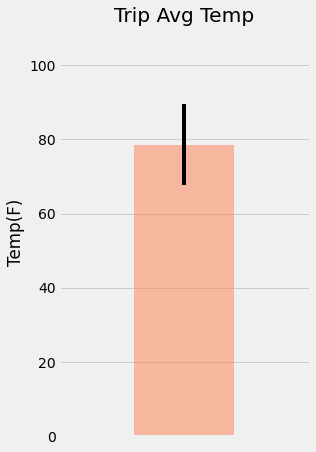

In [26]:
# Plot the results from your previous query as a bar chart. 

tmin = calc_temps('2017-07-15', '2017-07-25')[0][0]
tavg = calc_temps('2017-07-15', '2017-07-25')[0][1]
tmax = calc_temps('2017-07-15', '2017-07-25')[0][2]

peak_to_peak = tmax - tmin

x_value = 1

plt.figure(figsize=(4,7))
plt.xticks([])
plt.bar(x_value ,tavg, yerr=peak_to_peak, color='coral', alpha=0.5, align='center')


plt.xlim(0, 2)
plt.ylim(0, 110)
plt.ylabel("Temp(F)")
plt.title("Trip Avg Temp")
plt.show()




# Daily Rainfall Average

In [27]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation


rainfall = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
        filter(Measurement.station == Station.station).\
        filter(Measurement.date >= '2017-07-15').filter(Measurement.date <= '2017-07-25').\
        group_by(Station.station).\
        order_by(func.sum(Measurement.prcp).desc()).all()

rainfall



[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  10.4),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  1.88),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  1.6700000000000002),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 1.11),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.38),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  0.21000000000000002),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0)]

In [28]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [29]:
# calculate the daily normals for your trip

date_list = ['2021-07-15', '2021-07-16','2021-07-17','2021-07-18','2021-07-19','2021-07-20',
            '2021-07-21', '2021-07-22', '2021-07-23', '2021-07-24', '2021-07-25']
normals_list = []

for i in range(15, 26):
    normals_list.append(daily_normals(f'07-{i}')[0])

# Creating a dataframe to include daily normals and dates

normals_df = pd.DataFrame(normals_list, columns=["Tmin", "Tavg", "Tmax"])
normals_df['Date'] = date_list
normals_df.set_index('Date', inplace=True)
normals_df = normals_df.sort_values(by='Date', ascending=True)
normals_df


,Tmin,Tavg,Tmax
Date,,,
2021-07-15,68.0,76.254237,82.0
2021-07-16,70.0,76.344828,83.0
2021-07-17,70.0,76.301887,83.0
2021-07-18,72.0,76.637931,83.0
2021-07-19,68.0,75.890909,83.0
2021-07-20,69.0,75.462963,82.0
2021-07-21,69.0,76.924528,83.0
2021-07-22,69.0,75.788462,81.0
2021-07-23,70.0,76.203704,84.0


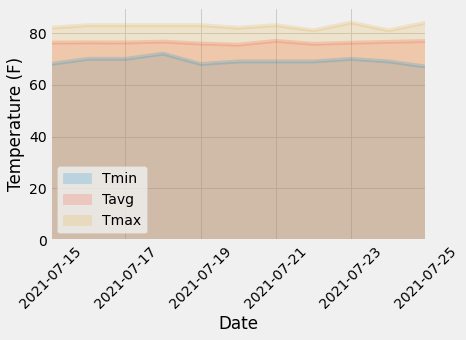

In [38]:
normals_df.plot.area(stacked=False, rot=45, alpha=0.2)
plt.legend(loc=0)
plt.ylabel('Temperature (F)')
plt.ylim(0, 90)
plt.xlim(0, 10)
plt.show()
